# LSTM AutoEncoder for anomaly Detection

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

In [8]:
dataframe = pd.read_csv('GE.csv')
df = dataframe[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])

C:\Users\VINAYA~1\AppData\Local\Temp/ipykernel_4604/2156328336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [9]:
df.head()

,Date,Close
0,2018-01-02,107.968536
1,2018-01-03,108.989372
2,2018-01-04,111.271240
3,2018-01-05,111.331291
4,2018-01-08,109.770012


<AxesSubplot:xlabel='Date', ylabel='Close'>

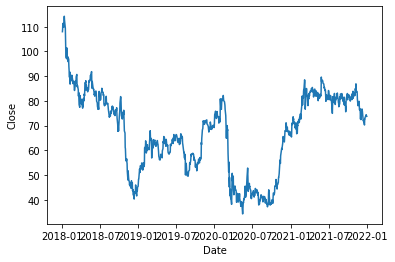

In [50]:
sns.lineplot(x=df['Date'], y=df['Close'])


In [13]:
print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

Start date is:  2018-01-02 00:00:00
End date is:  2021-12-31 00:00:00


In [19]:
#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['Date'] <= '2020-10-12'], df.loc[df['Date'] > '2020-10-12']

In [20]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\VINAYA~1\AppData\Local\Temp/ipykernel_4604/1980345901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
C:\Users\VINAYA~1\AppData\Local\Temp/ipykernel_4604/1980345901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [21]:
seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [22]:
trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

# Model Building

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))

In [24]:
model.compile(optimizer='adam', loss='mae')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [26]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
19/19 [==============================] - 4s 68ms/step - loss: 0.2917 - val_loss: 0.2215
Epoch 2/10
19/19 [==============================] - 1s 31ms/step - loss: 0.1625 - val_loss: 0.1621
Epoch 3/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1442 - val_loss: 0.1426
Epoch 4/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1387 - val_loss: 0.1228
Epoch 5/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1305 - val_loss: 0.2232
Epoch 6/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1290 - val_loss: 0.1477
Epoch 7/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1220 - val_loss: 0.1039
Epoch 8/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1193 - val_loss: 0.0992
Epoch 9/10
19/19 [==============================] - 1s 31ms/step - loss: 0.1191 - val_loss: 0.1015
Epoch 10/10
19/19 [==============================] - 1s 32ms/step - loss: 0.1148 - val_loss: 0.0880


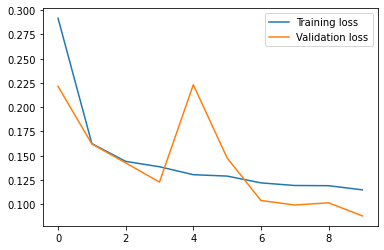

In [27]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

(array([ 95., 105., 121.,  86.,  60.,  46.,  24.,  21.,  26.,  13.,  14.,
         11.,   6.,   5.,   4.,   4.,   3.,   4.,   6.,   3.,   0.,   2.,
          1.,   1.,   1.,   0.,   0.,   3.,   1.,   4.]),
 array([0.06150632, 0.11003364, 0.15856096, 0.20708827, 0.25561559,
        0.3041429 , 0.35267022, 0.40119753, 0.44972485, 0.49825217,
        0.54677948, 0.5953068 , 0.64383411, 0.69236143, 0.74088874,
        0.78941606, 0.83794338, 0.88647069, 0.93499801, 0.98352532,
        1.03205264, 1.08057995, 1.12910727, 1.17763459, 1.2261619 ,
        1.27468922, 1.32321653, 1.37174385, 1.42027116, 1.46879848,
        1.5173258 ]),
 <BarContainer object of 30 artists>)

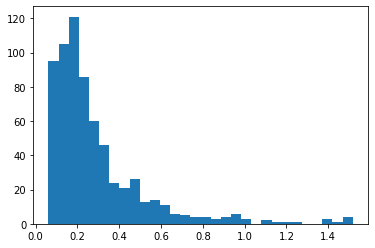

In [28]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

In [39]:
max_trainMAE = 0.5  #or Define 90% value of max as threshold.

(array([19., 56., 35., 40., 20., 21., 10.,  8.,  8., 11.,  4.,  5.,  3.,
         5.,  3.,  1.,  3.,  4.,  2.,  0.,  2.,  1.,  4.,  1.,  3.,  3.,
         3.,  0.,  1.,  2.]),
 array([0.06704591, 0.08979191, 0.11253791, 0.13528391, 0.1580299 ,
        0.1807759 , 0.2035219 , 0.2262679 , 0.24901389, 0.27175989,
        0.29450589, 0.31725189, 0.33999788, 0.36274388, 0.38548988,
        0.40823588, 0.43098187, 0.45372787, 0.47647387, 0.49921986,
        0.52196586, 0.54471186, 0.56745786, 0.59020385, 0.61294985,
        0.63569585, 0.65844185, 0.68118784, 0.70393384, 0.72667984,
        0.74942584]),
 <BarContainer object of 30 artists>)

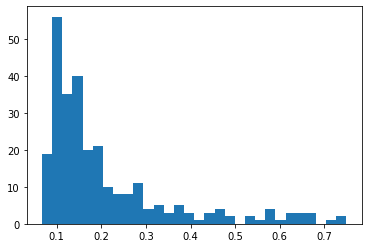

In [40]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

# Anamoly Part

In [41]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

<AxesSubplot:xlabel='Date', ylabel='testMAE'>

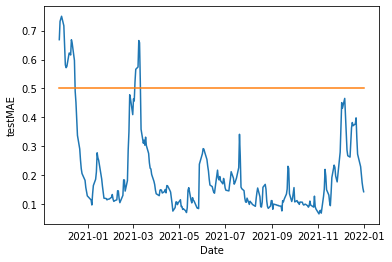

In [42]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [43]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

<AxesSubplot:xlabel='Date'>

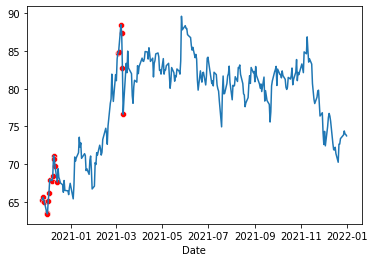

In [45]:
#Plot anomalies for test data
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df[['Close']]).flatten())
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies[['Close']]).flatten(), color='r')

In [ ]:
#old plot
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')